In [1]:
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')

# Check if TensorFlow has access to GPU
if len(physical_devices) > 0:
    print(f"GPUs detected: {len(physical_devices)}")
    # Set memory growth to True for all GPUs
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(f"Memory growth set to True")
else:
    print("No GPUs detected. Please check your CUDA and cuDNN setup.")

GPUs detected: 8
Memory growth set to True


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, BatchNormalization, concatenate, Layer, Lambda, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

In [3]:
#load and normalize the data
data = np.load('rawdata.npz')
substructure_variables = ['w', 'q', 'm', 'r', 'tau1s', 'tau2s']
data_streams = ['_true', '_true_alt', '_reco', '_reco_alt']

normalize = True
    
for var_name in data.files:
    globals()[var_name] = data[var_name][:150000]
    
if normalize:
    for var_name in substructure_variables:
        mu = np.mean(globals()[var_name+data_streams[0]])
        sig = np.std(globals()[var_name + data_streams[0]])
        for stream in data_streams:
            globals()[var_name+stream] = (globals()[var_name+stream] - mu)/sig

In [4]:
N = len(m_true)

xvals_truth = np.array([np.concatenate([globals()[f"{var_name}_true_alt"], globals()[f"{var_name}_true"]]) for var_name in substructure_variables]).T
xvals_reco = np.array([np.concatenate([globals()[f"{var_name}_reco_alt"], globals()[f"{var_name}_reco"]]) for var_name in substructure_variables]).T
                    
yvals = np.concatenate([np.zeros(N, dtype=np.float32),np.ones(N, dtype=np.float32)])

X_train_truth, X_test_truth, X_train_reco, X_test_reco, Y_train, Y_test = train_test_split(
    xvals_truth, xvals_reco, yvals)


In [5]:
import tensorflow as tf

tf.keras.utils.get_custom_objects().clear()

@tf.keras.utils.register_keras_serializable(package="Custom", name="weighted_binary_crossentropy")
def weighted_binary_crossentropy(target, output, weights):
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    output = tf.convert_to_tensor(output, dtype=tf.float32)
    weights = tf.convert_to_tensor(weights, dtype=tf.float32)
    
    epsilon_ = tf.keras.backend.epsilon()
    output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)
    
    weights_1 = tf.reduce_sum(target * weights)
    weights_0 = tf.reduce_sum((1 - target) * weights)
    
    bce_1 = target * tf.math.log(output + epsilon_) * weights / weights_1
    bce_0 = (1 - target) * tf.math.log(1 - output + epsilon_) * weights / weights_0
    weighted_bce = -tf.reduce_mean(bce_1 + bce_0) * tf.cast(tf.shape(target)[0], dtype=tf.float32)
    return weighted_bce
    
@tf.keras.utils.register_keras_serializable(package="Custom", name="weighted_binary_crossentropy_GAN")
def weighted_binary_crossentropy_GAN(target, output, weights):
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    output = tf.convert_to_tensor(output, dtype=tf.float32)
    weights = tf.convert_to_tensor(weights, dtype=tf.float32)

    epsilon_ = tf.keras.backend.epsilon()
    output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)
    
    weights_sum = tf.reduce_sum((1 - target) * weights)
    bce = weights * (1 - target) * tf.math.log(1 - output + epsilon_) / weights_sum
    weighted_bce = 2 * tf.reduce_mean(bce) * tf.cast(tf.shape(target)[0], dtype=tf.float32)
    return weighted_bce


In [6]:
# Model configuration
gen_model_width = 100
gen_model_depth = 5
disc_model_width = 50
disc_model_depth = 3
dropout_rate = 0.0

# Generator model
def build_generator(input_shape):
    gen_input = Input(shape=(input_shape,))
    x = gen_input
    
    # Initialize kernel
    kernel_init = RandomNormal(mean=0.0, stddev=0.2)
    
    # Hidden layers
    for _ in range(gen_model_depth):
        x = Dense(gen_model_width, activation='relu', use_bias=False, kernel_initializer=kernel_init if _ == 0 else None)(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    # Output layer
    x = Dense(1, activation='softplus', use_bias=False)(x)
    outputs = Lambda(lambda x: x / K.log(2.0))(x)
    return Model(inputs=gen_input, outputs=outputs)

# Discriminator model
def build_discriminator(input_shape):
    disc_inputs = Input(shape=(input_shape,))
    
    # Hidden layers
    x = disc_inputs
    for _ in range(disc_model_depth):
        x = Dense(disc_model_width, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.2) if _ == 0 else None)(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=disc_inputs, outputs=outputs)

# Create the models
model_generator = build_generator(xvals_truth.shape[1])
model_discriminator = build_discriminator(xvals_reco.shape[1])

In [7]:
optimizer_disc = Adam(learning_rate=0.0001, beta_1 = 0.3)
optimizer_gen = Adam(learning_rate=0.0002, beta_1 = 0.5)

@tf.function
def train_step_discriminator(X_detector_batch, Y_batch, W_batch):
    model_discriminator.trainable = True
    model_generator.trainable = False
    with tf.GradientTape() as tape:
        predictions = model_discriminator(X_detector_batch, training=True)
        loss = weighted_binary_crossentropy(Y_batch, predictions, W_batch)
    grads = tape.gradient(loss, model_discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(grads, model_discriminator.trainable_variables))
    return loss

@tf.function
def train_step_gan(X_particle_batch, X_detector_batch, Y_batch):
    model_discriminator.trainable = False
    model_generator.trainable = True
    with tf.GradientTape() as tape:
        W_batch = model_generator(X_particle_batch, training=True) 
        W_batch = tf.where(Y_batch == 1, 1.0, tf.squeeze(W_batch))
        discriminator_output = model_discriminator(X_detector_batch, training=False)  
        loss = weighted_binary_crossentropy_GAN(Y_batch, discriminator_output, W_batch)
    grads = tape.gradient(loss, model_generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(grads, model_generator.trainable_variables))
    return loss
    
discriminator_losses = []
generator_losses = []
disc_loss_avg = []
gen_loss_avg = []

In [8]:
X_train_reco.shape

(225000, 6)

In [9]:
n_epochs = 10
batch_size = X_train_reco.shape[0]//100
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_reco, X_train_truth, Y_train)).batch(batch_size)

m = 2  # Number of generator updates
n = 1  # Number of discriminator updates

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")

    for X_detector_batch, X_particle_batch, Y_batch in train_dataset:
        # Discriminator update loop
        for _ in range(n):
            model_generator.trainable = False
            W_batch = model_generator.predict(X_particle_batch, verbose=0)
            W_batch = tf.where(Y_batch == 1, 1.0, tf.squeeze(W_batch))
            d_loss = train_step_discriminator(X_detector_batch, Y_batch, W_batch)
            discriminator_losses.append(d_loss.numpy())

        # Generator update loop
        for _ in range(m):
            alt_indices = tf.where(Y_batch == 0)
            X_particle_alt = tf.gather_nd(X_particle_batch, alt_indices)
            X_detector_alt = tf.gather_nd(X_detector_batch, alt_indices)
            Y_alt = tf.gather_nd(Y_batch, alt_indices)
            g_loss = train_step_gan(X_particle_alt, X_detector_alt, Y_alt)
            generator_losses.append(g_loss.numpy())

    # Log and printing specs about the model
    avg_d_loss = np.mean(discriminator_losses[-n*len(train_dataset):])
    avg_g_loss = np.mean(generator_losses[-m*len(train_dataset):])
    gen_loss_avg.append(avg_g_loss)
    disc_loss_avg.append(avg_d_loss)   
    print(f"Epoch {epoch+1} completed. Discriminator Loss: {avg_d_loss}, Generator Loss: {avg_g_loss}")

Epoch 1/10


I0000 00:00:1712265199.743025 4095839 service.cc:145] XLA service 0x7fc7480088c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712265199.743058 4095839 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712265199.743066 4095839 service.cc:153]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712265199.743070 4095839 service.cc:153]   StreamExecutor device (2): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712265199.743072 4095839 service.cc:153]   StreamExecutor device (3): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712265199.743075 4095839 service.cc:153]   StreamExecutor device (4): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712265199.743077 4095839 service.cc:153]   StreamExecutor device (5): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712265199.743080 4095839 service.cc:153]   StreamE

Epoch 1 completed. Discriminator Loss: 1.387945532798767, Generator Loss: -1.3972429037094116
Epoch 2/10
Epoch 2 completed. Discriminator Loss: 1.3865259885787964, Generator Loss: -1.385581374168396
Epoch 3/10
Epoch 3 completed. Discriminator Loss: 1.3864262104034424, Generator Loss: -1.3857128620147705
Epoch 4/10
Epoch 4 completed. Discriminator Loss: 1.3863863945007324, Generator Loss: -1.3858957290649414
Epoch 5/10
Epoch 5 completed. Discriminator Loss: 1.3863624334335327, Generator Loss: -1.386067509651184
Epoch 6/10
Epoch 6 completed. Discriminator Loss: 1.3863470554351807, Generator Loss: -1.386163592338562
Epoch 7/10
Epoch 7 completed. Discriminator Loss: 1.3863368034362793, Generator Loss: -1.386205792427063
Epoch 8/10
Epoch 8 completed. Discriminator Loss: 1.3863297700881958, Generator Loss: -1.3862330913543701
Epoch 9/10
Epoch 9 completed. Discriminator Loss: 1.3863247632980347, Generator Loss: -1.3862502574920654
Epoch 10/10
Epoch 10 completed. Discriminator Loss: 1.38632130

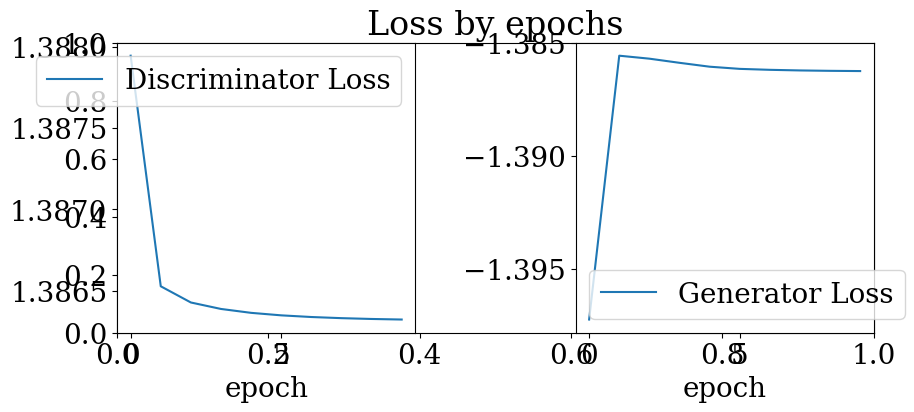

In [10]:
plt.figure(figsize=(10, 5))
plt.title('Loss by epochs')

# Discriminator Loss
plt.subplot(1, 2, 1)
plt.plot(disc_loss_avg, label='Discriminator Loss')
plt.xlabel('epoch')
plt.legend()

# Generator Loss
plt.subplot(1, 2, 2)
plt.plot(gen_loss_avg, label='Generator Loss')
plt.xlabel('epoch')
plt.legend()

plt.tight_layout()
plt.show()

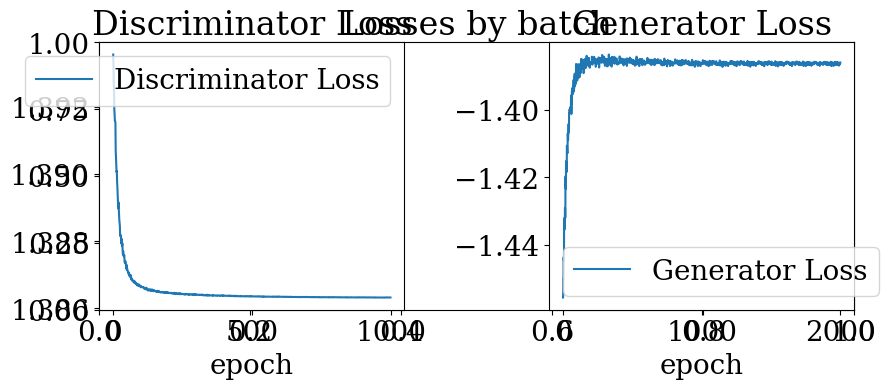

In [11]:
plt.figure(figsize=(10, 5))
plt.title("Losses by batch")

# Discriminator Loss
plt.subplot(1, 2, 1) 
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('epoch')
plt.legend()

# Generator Loss
plt.subplot(1, 2, 2) 
plt.plot(generator_losses, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
#Now apply the generator to x_true_alt, to get the weights at truth level
weights = model_generator.predict(X_test_truth[Y_test==0])

1176/1176 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


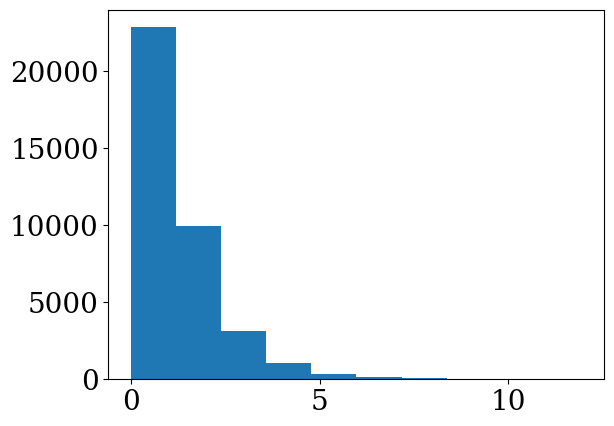

In [13]:
plt.hist(weights)
plt.show()

In [14]:
def moment(x, n, w=None):
    return np.average(x**n, weights = w)

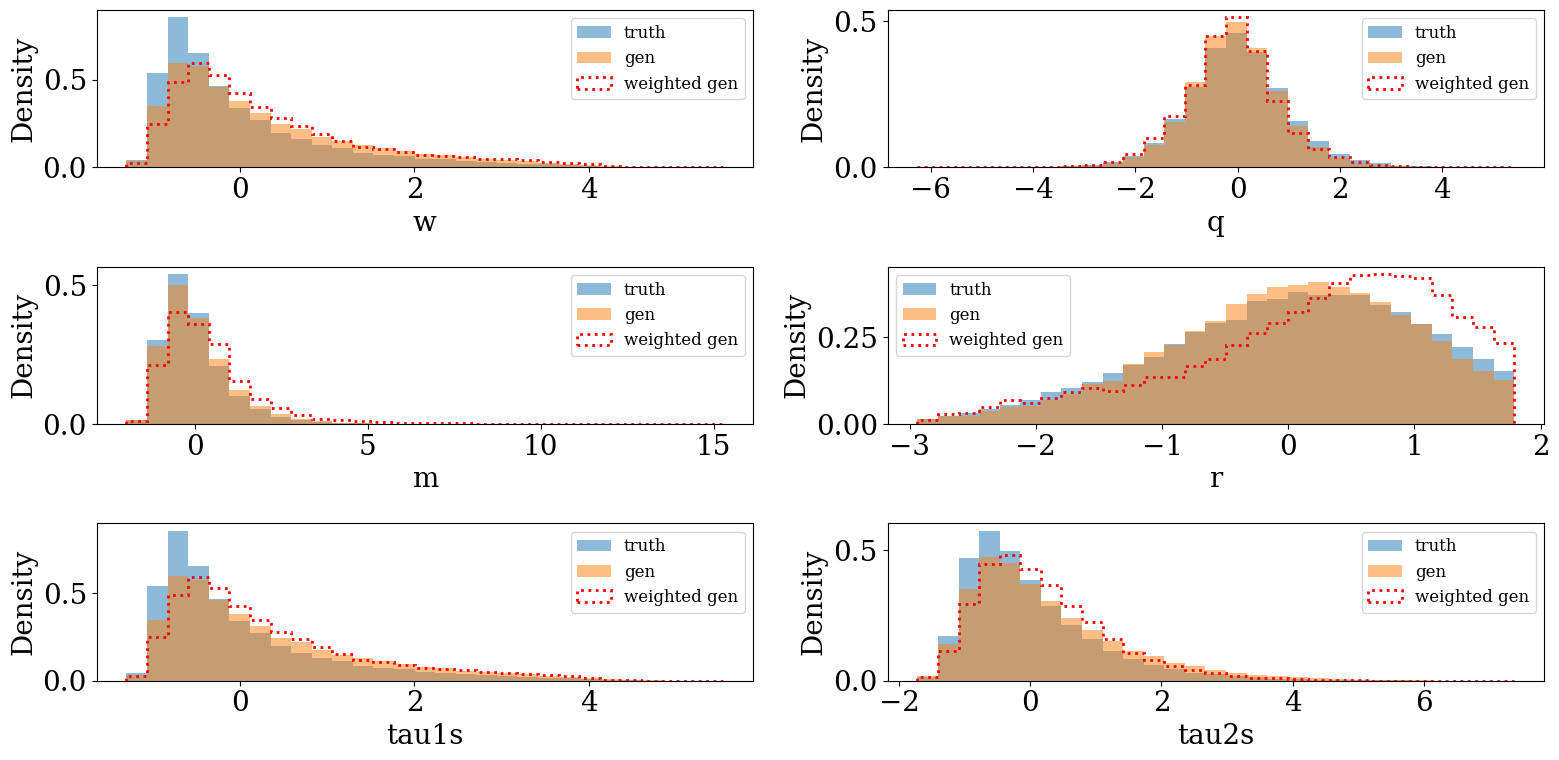

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(16, 8))
axs = axs.flatten()
nbins = 30
density = True

for i, var_name in enumerate(substructure_variables):
    X = X_test_truth[:, i]*np.std(globals()[var_name + '_true']) + np.mean(globals()[var_name + '_true'])
    bins = np.linspace(X.min(), X.max(), nbins)
    
    axs[i].hist(X[Y_test == 1], bins=bins, alpha=0.5, label="truth", density=density, zorder=-1)
    axs[i].hist(X[Y_test == 0], bins=bins, alpha=0.5, label="gen", density=density, zorder=0)
    axs[i].hist(X[Y_test == 0], bins=bins, weights=weights,
                histtype="step", color="red", ls=":", lw=2, label="weighted gen", density=density, zorder=1)
    
    axs[i].legend(fontsize=12)
    axs[i].set_ylabel("Density")
    axs[i].set_xlabel(var_name)

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [16]:
for n in range(1, 5):
    print("Moment", i)
    for i, var_name in enumerate(substructure_variables):
        X = X_test_truth[:, i]*np.std(globals()[var_name + '_true']) + np.mean(globals()[var_name + '_true'])
        print(f"\t{var_name} truth: {moment(X[Y_test == 1], n) :}")
        print(f"\t{var_name} gen: {moment(X[Y_test == 0], n):}")
        print(f"\t{var_name} unfolded: {moment(X[Y_test == 0], n, weights[:, 0]):}")

Moment 5
	w truth: 0.0025010750947212453
	w gen: 0.2879197292491327
	w unfolded: 0.33558024408457404
	q truth: -0.005445697312407821
	q gen: -0.05293856813834905
	q unfolded: -0.10142196174024248
	m truth: 0.0060890118920510555
	m gen: 0.1082748276684086
	m unfolded: 0.4542357879861737
	r truth: -0.002771939565913816
	r gen: -0.004046575901162359
	r unfolded: 0.22464934627539715
	tau1s truth: 0.0025010750947212453
	tau1s gen: 0.2879197292491327
	tau1s unfolded: 0.33558024408457404
	tau2s truth: 0.005399851209614134
	tau2s gen: 0.2690877916265529
	tau2s unfolded: 0.2168767962025414
Moment 5
	w truth: 1.0010769289282762
	w gen: 1.3454440801021148
	w unfolded: 1.3249226114932255
	q truth: 0.9887225755407695
	q gen: 0.8157561740823939
	q unfolded: 0.8706074858873138
	m truth: 1.024592987729696
	m gen: 1.166652116670396
	m unfolded: 2.2259613527060713
	r truth: 0.9982775237863329
	r gen: 0.9047771362066321
	r unfolded: 1.0994016396185535
	tau1s truth: 1.0010769289282762
	tau1s gen: 1.345444